# Explore Article Data to Check Quality

Make sure to explore the scRNA-seq data before doing any preprocessing modeling to see if the mutation that we are looking at here can actually explain any of the variance in the output data.

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

In [2]:
adata = sc.read_10x_mtx(
    path="../../resources/GSE117826/GSM3739219_MF02",
    var_names="gene_symbols",
    make_unique=True,
)

In [3]:
adata

AnnData object with n_obs × n_vars = 3487 × 32738
    var: 'gene_ids', 'feature_types'

In [4]:
cell_meta_raw = pd.read_csv(
    "../../resources/GSE117826/GSM3739219_MF02/GSM3739225_MF02.CALR.txt",
    sep="\t",
    index_col=0,
)


def classify_genotype(wt, mut, min_total=3):
    total = wt + mut
    if total < min_total:
        return "NG"  # Not genotyped (too low coverage)
    elif mut > wt:
        return "MT"
    elif wt > mut:
        return "WT"
    else:
        return "NG"


cell_meta_raw["perturbation"] = cell_meta_raw.apply(
    lambda row: classify_genotype(row["num.WT.call"], row["num.MUT.call"]), axis=1
)
cell_meta_raw.index = (
    cell_meta_raw.index + "-1"
)  # Add suffix to match barcodes in adata
cell_meta_raw

,num.WT.call,num.MUT.call,perturbation
BC,,,
TCGGGACGTGGCTGAA-1,0,3,MT
ATGAAAGAGATGGTAT-1,86,53,WT
CTGCTCATCCCTTGTG-1,15,23,MT
GCAACCGAGTTAACGA-1,63,51,WT
AAAGAACCATCCAACA-1,62,44,WT
...,...,...,...
CGTGAATAGCTGACTT-1,1,0,NG
GATAGAAAGGATGGCT-1,1,0,NG
GGGCTACAGCGTCTCG-1,1,0,NG


In [5]:
# Calculate quality control metrics
adata.obs["perturbation"] = cell_meta_raw["perturbation"]
adata.obs["genotype"] = cell_meta_raw["perturbation"].map(
    {"MT": "Mutant", "WT": "Wild-type", "NG": "Not-genotyped"}
)

# Convert genotype to categorical for plotting
adata.obs["genotype"] = adata.obs["genotype"].astype("category")

print(f"Data shape: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Genotype distribution:\n{adata.obs['genotype'].value_counts()}")
adata

Data shape: 3487 cells x 32738 genes
Genotype distribution:
genotype
Wild-type        1435
Mutant           1085
Not-genotyped     380
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 3487 × 32738
    obs: 'perturbation', 'genotype'
    var: 'gene_ids', 'feature_types'

In [6]:
adata.obs["genotype"]

AAACCCACATTCGATG-1    Not-genotyped
AAACCCAGTATTGGCT-1        Wild-type
AAACCCATCTTCACGC-1        Wild-type
AAACGAAAGAATACAC-1        Wild-type
AAACGAACATCTGCGG-1           Mutant
                          ...      
TTTGGTTTCAAAGCCT-1           Mutant
TTTGGTTTCGACCATA-1        Wild-type
TTTGTTGAGGACTATA-1        Wild-type
TTTGTTGCATCCGGCA-1        Wild-type
TTTGTTGGTGGGTATG-1        Wild-type
Name: genotype, Length: 3487, dtype: category
Categories (3, object): ['Mutant', 'Not-genotyped', 'Wild-type']

# Debug the genotype mapping issue
print("Perturbation values:")
print(adata.obs["perturbation"].value_counts())
print("\nUnique perturbation values:")
print(adata.obs["perturbation"].unique())
print("\nGenotype values:")
print(adata.obs["genotype"].value_counts())
print("\nChecking if perturbation column has the expected values...")
print("Expected values: 'MT', 'WT', 'NG'")
print("Actual values:", adata.obs["perturbation"].unique())ntrol Metrics

In [7]:
# Calculate QC metrics
# Mitochondrial genes (MT- prefix)
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# Ribosomal genes (RP[SL] prefix)
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# Hemoglobin genes (HB prefix)
adata.var["hb"] = adata.var_names.str.startswith("HB")

# Calculate basic QC metrics
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

# Manually calculate percentage of mitochondrial and ribosomal genes
adata.obs["pct_counts_mt"] = (
    np.array(adata[:, adata.var["mt"]].X.sum(axis=1)).flatten()
    / adata.obs["total_counts"]
    * 100
)
adata.obs["pct_counts_ribo"] = (
    np.array(adata[:, adata.var["ribo"]].X.sum(axis=1)).flatten()
    / adata.obs["total_counts"]
    * 100
)

# Additional QC metrics
adata.obs["n_genes_by_counts"] = adata.obs["n_genes_by_counts"].astype(int)
adata.obs["total_counts"] = adata.obs["total_counts"].astype(int)

print("QC metrics calculated:")
print(
    f"- Total counts per cell: {adata.obs['total_counts'].min():.0f} - {adata.obs['total_counts'].max():.0f}"
)
print(
    f"- Genes per cell: {adata.obs['n_genes_by_counts'].min()} - {adata.obs['n_genes_by_counts'].max()}"
)
print(f"- Mitochondrial genes: {adata.var['mt'].sum()}")
print(f"- Ribosomal genes: {adata.var['ribo'].sum()}")
print(f"- Hemoglobin genes: {adata.var['hb'].sum()}")

adata.obs[
    ["total_counts", "n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"]
].head()

QC metrics calculated:
- Total counts per cell: 500 - 38602
- Genes per cell: 17 - 6023
- Mitochondrial genes: 13
- Ribosomal genes: 106
- Hemoglobin genes: 14


,total_counts,n_genes_by_counts,pct_counts_mt,pct_counts_ribo
AAACCCACATTCGATG-1,2040,827,4.656863,36.127453
AAACCCAGTATTGGCT-1,7303,2364,3.436944,38.573189
AAACCCATCTTCACGC-1,10880,2663,2.601103,47.904411
AAACGAAAGAATACAC-1,9131,2168,3.668820,48.636513
AAACGAACATCTGCGG-1,12377,3097,4.152864,39.452209


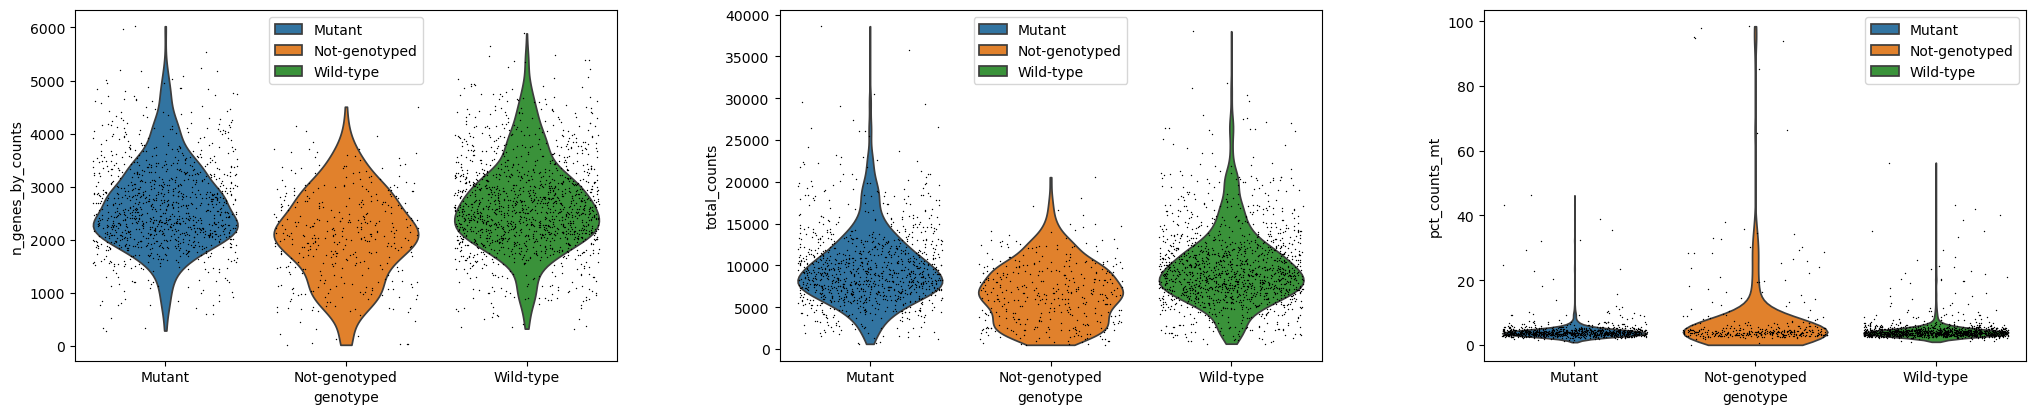

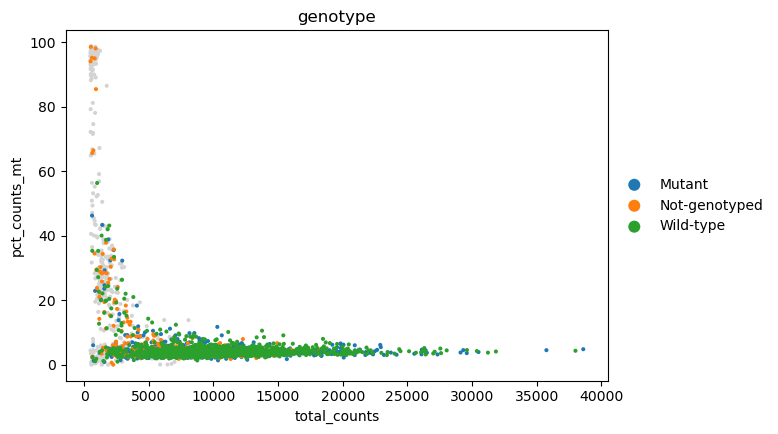

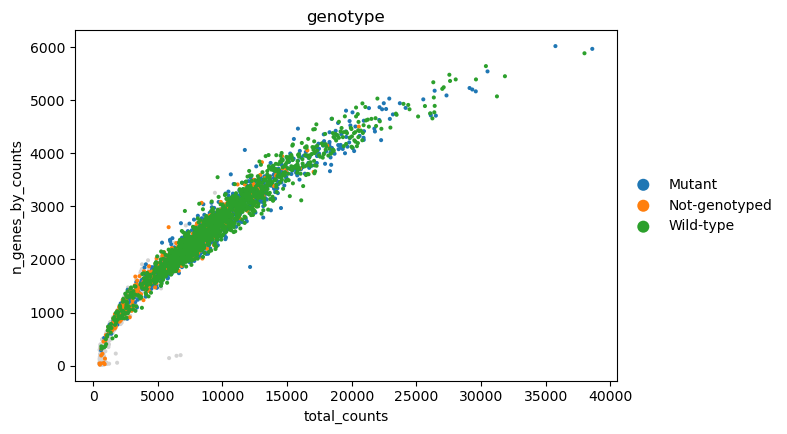

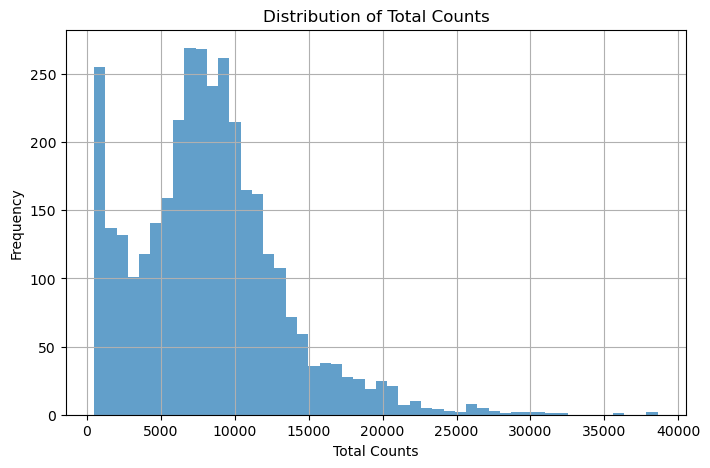

In [8]:
# Visualize QC metrics
# Violin plots for QC metrics by genotype
ax = sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    groupby="genotype",
    #    title="QC Metrics by Genotype",
)

# Scatter plot - Total Counts vs Mitochondrial %
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", color="genotype")

# Scatter plot - Total Counts vs Number of Genes
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", color="genotype")

# Distribution of total counts
plt.figure(figsize=(8, 5))
adata.obs["total_counts"].hist(bins=50, alpha=0.7)
plt.xlabel("Total Counts")
plt.ylabel("Frequency")
plt.title("Distribution of Total Counts")
plt.show()

## Step 2: Cell and Gene Filtering

In [9]:
# Save raw data
adata.raw = adata

# Set filtering thresholds based on data distribution
min_genes = 200  # Minimum number of genes expressed in a cell
min_cells = 3  # Minimum number of cells expressing a gene
max_genes = 5000  # Maximum number of genes (potential doublets)
max_mt_pct = 20  # Maximum mitochondrial gene percentage

print(f"Before filtering: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Filter cells
#  sc.pp.filter_cells(adata, min_genes=min_genes)
print(f"After min_genes filter: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Filter genes
#  sc.pp.filter_genes(adata, min_cells=min_cells)
print(f"After min_cells filter: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Filter cells with too many genes (potential doublets)
#  adata = adata[adata.obs.n_genes_by_counts < max_genes, :]
print(f"After max_genes filter: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Filter cells with high mitochondrial percentage
#  adata = adata[adata.obs.pct_counts_mt < max_mt_pct, :]
print(f"After mitochondrial filter: {adata.shape[0]} cells by {adata.shape[1]} genes")

# Check genotype distribution after filtering
print(f"\nGenotype distribution after filtering:")
print(adata.obs["genotype"].value_counts())

Before filtering: 3487 cells by 32738 genes
After min_genes filter: 3487 cells by 32738 genes
After min_cells filter: 3487 cells by 32738 genes
After max_genes filter: 3487 cells by 32738 genes
After mitochondrial filter: 3487 cells by 32738 genes

Genotype distribution after filtering:
genotype
Wild-type        1435
Mutant           1085
Not-genotyped     380
Name: count, dtype: int64


## Step 3: Normalization and Log Transformation

Normalization completed:
- Library size normalized to 10,000 reads per cell
- Log(x+1) transformation applied
- Data range: 0.00 to 8.90


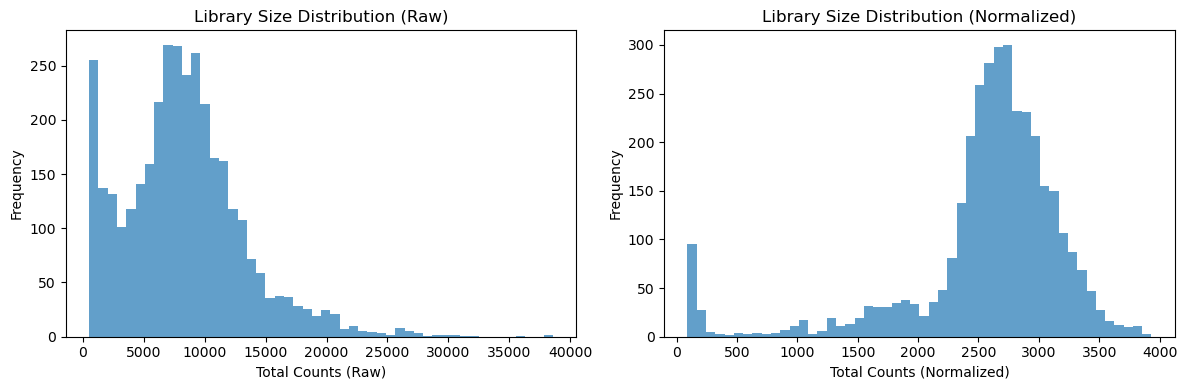

In [10]:
# Normalize to 10,000 reads per cell (CPM-like normalization)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform (log(x + 1))
sc.pp.log1p(adata)

# Save normalized data
adata.layers["normalized"] = adata.X.copy()

print("Normalization completed:")
print(f"- Library size normalized to 10,000 reads per cell")
print(f"- Log(x+1) transformation applied")
print(f"- Data range: {adata.X.min():.2f} to {adata.X.max():.2f}")

# Plot distribution before and after normalization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Raw data distribution (from raw.X)
axes[0].hist(np.array(adata.raw.X.sum(axis=1)).flatten(), bins=50, alpha=0.7)
axes[0].set_xlabel("Total Counts (Raw)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Library Size Distribution (Raw)")

# Normalized data distribution
axes[1].hist(np.array(adata.X.sum(axis=1)).flatten(), bins=50, alpha=0.7)
axes[1].set_xlabel("Total Counts (Normalized)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Library Size Distribution (Normalized)")

plt.tight_layout()
plt.show()

## Step 4: Highly Variable Gene Selection

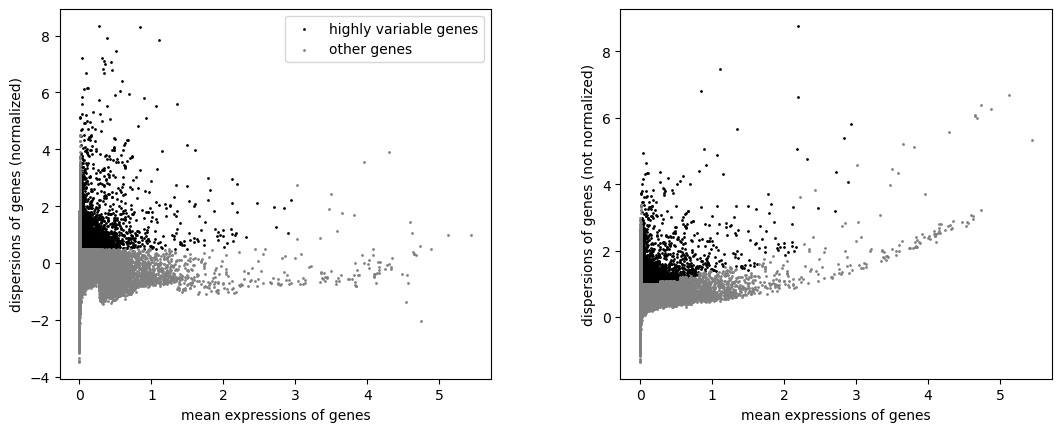

Number of highly variable genes: 3803
Total genes: 32738
Percentage of highly variable genes: 11.6%

Top 10 highly variable genes:
           means  dispersions  dispersions_norm
CLDN5   0.274523     4.364756          8.338981
HBA1    0.842115     6.800158          8.310383
PTCRA   0.383510     4.187885          7.916237
HBA2    1.109098     7.474980          7.830184
TUBA4A  0.510137     3.992351          7.448884
GDF15   0.040774     4.951947          7.205060
TMEM40  0.316148     3.888929          7.201694
CLEC1B  0.336191     3.854894          7.120346
GP9     0.440108     3.833862          7.070076
TREML1  0.349178     3.809631          7.012160


In [11]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot highly variable genes
sc.pl.highly_variable_genes(adata)

print(f"Number of highly variable genes: {adata.var['highly_variable'].sum()}")
print(f"Total genes: {adata.shape[1]}")
print(
    f"Percentage of highly variable genes: {adata.var['highly_variable'].sum() / adata.shape[1] * 100:.1f}%"
)

# Show top highly variable genes
hvg_df = adata.var[adata.var["highly_variable"]].sort_values(
    "dispersions_norm", ascending=False
)
print("\nTop 10 highly variable genes:")
print(hvg_df[["means", "dispersions", "dispersions_norm"]].head(10))

## Step 5: Scaling and Centering

/opt/conda/envs/experimenting/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Scaling completed:
- Data centered to zero mean
- Scaled to unit variance
- Extreme values clipped to [-10, 10]
- Data range: -4.88 to 10.00


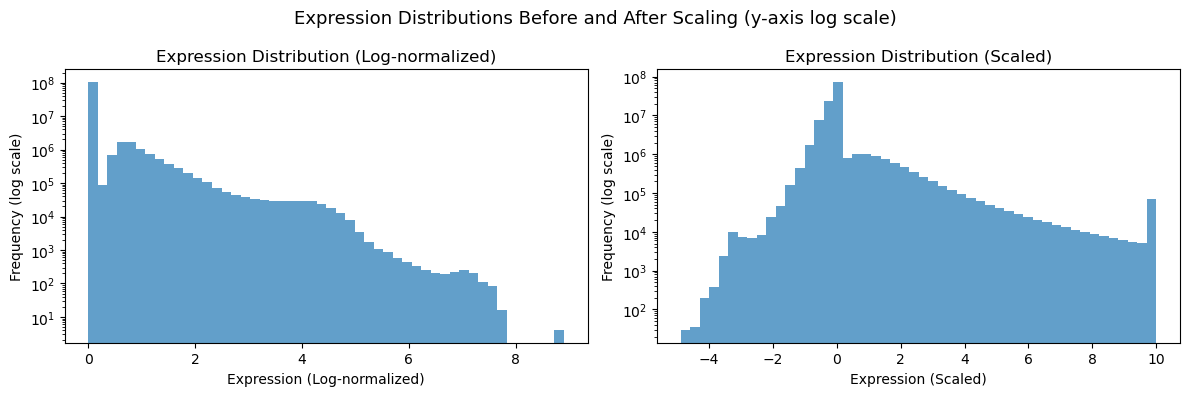

In [12]:
# Save normalized data before scaling
adata.layers["log_normalized"] = adata.X.copy()

# Scale data
sc.pp.scale(adata, max_value=10)  # Clip values to [-10, 10] to avoid extreme outliers

print("Scaling completed:")
print(f"- Data centered to zero mean")
print(f"- Scaled to unit variance")
print(f"- Extreme values clipped to [-10, 10]")
print(f"- Data range: {adata.X.min():.2f} to {adata.X.max():.2f}")

# Plot distribution before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Log-normalized data distribution
log_norm_data = (
    adata.layers["log_normalized"].toarray()
    if hasattr(adata.layers["log_normalized"], "toarray")
    else adata.layers["log_normalized"]
)
axes[0].hist(log_norm_data.flatten(), bins=50, alpha=0.7, log=True)
axes[0].set_xlabel("Expression (Log-normalized)")
axes[0].set_ylabel("Frequency (log scale)")
axes[0].set_title("Expression Distribution (Log-normalized)")

# Scaled data distribution
scaled_data = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
axes[1].hist(scaled_data.flatten(), bins=50, alpha=0.7, log=True)
axes[1].set_xlabel("Expression (Scaled)")
axes[1].set_ylabel("Frequency (log scale)")
axes[1].set_title("Expression Distribution (Scaled)")

fig.suptitle(
    "Expression Distributions Before and After Scaling (y-axis log scale)", fontsize=13
)

plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Expression Distributions Before and After Scaling')

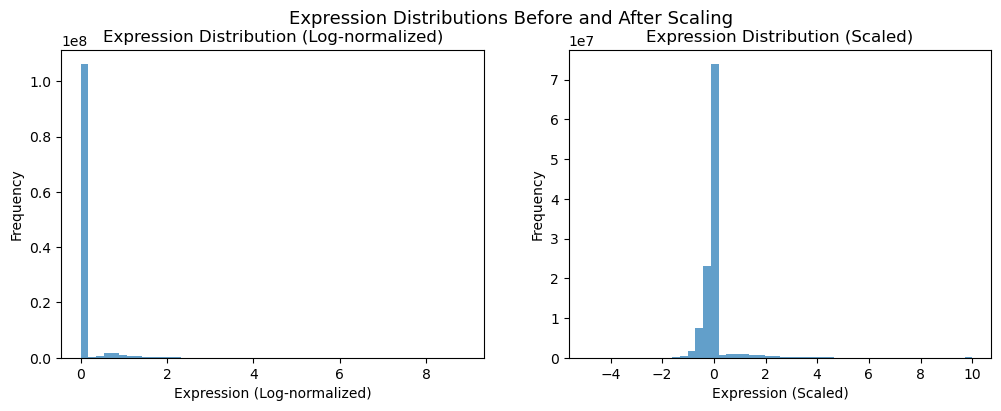

In [13]:
# Plot distribution before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Log-normalized data distribution
log_norm_data = (
    adata.layers["log_normalized"].toarray()
    if hasattr(adata.layers["log_normalized"], "toarray")
    else adata.layers["log_normalized"]
)

axes[0].hist(log_norm_data.flatten(), bins=50, alpha=0.7)
axes[0].set_xlabel("Expression (Log-normalized)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Expression Distribution (Log-normalized)")

# Scaled data distribution (linear scale)
axes[1].hist(scaled_data.flatten(), bins=50, alpha=0.7)
axes[1].set_xlabel("Expression (Scaled)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Expression Distribution (Scaled)")

fig.suptitle("Expression Distributions Before and After Scaling", fontsize=13)

## Step 6: Principal Component Analysis

Removed 748 outlier cells for cleaner PCA visualization
Plotting 2739 cells out of 3487 total cells

=== Original PCA plots (with outliers) ===


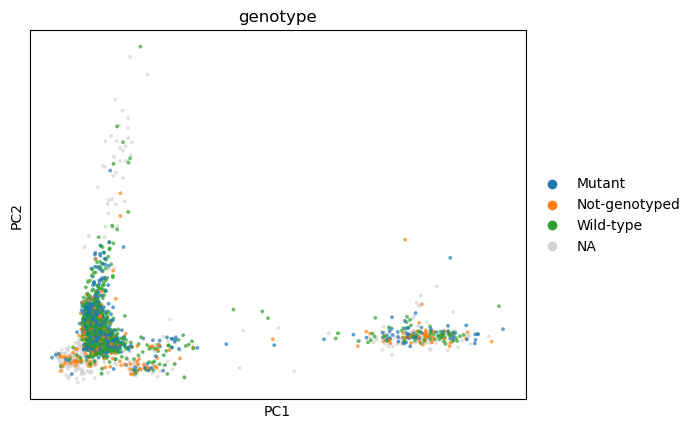

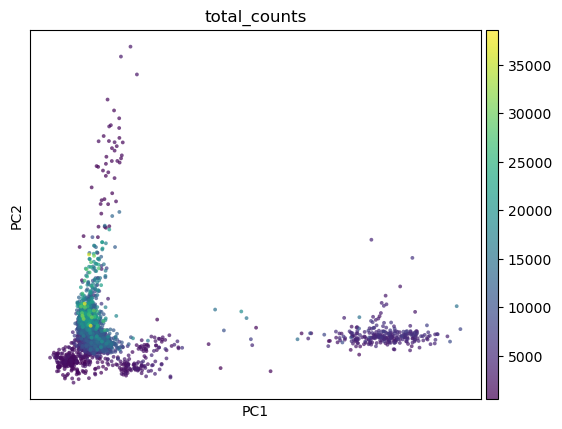

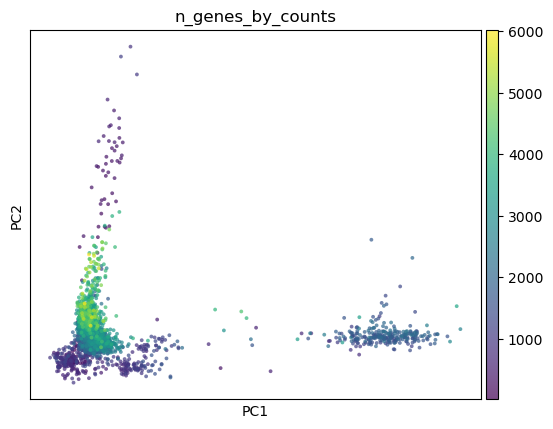


=== Cleaned PCA plots (outliers removed) ===


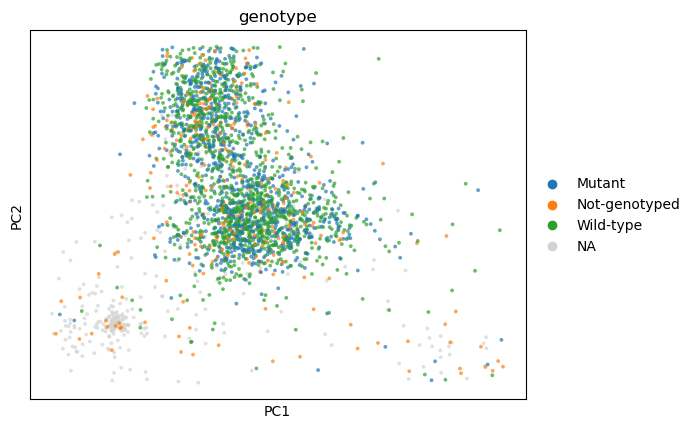

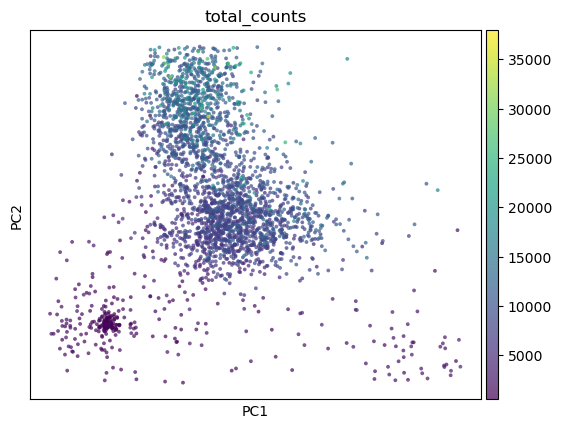

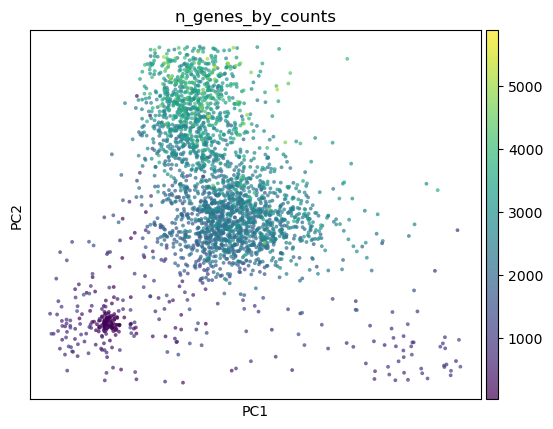

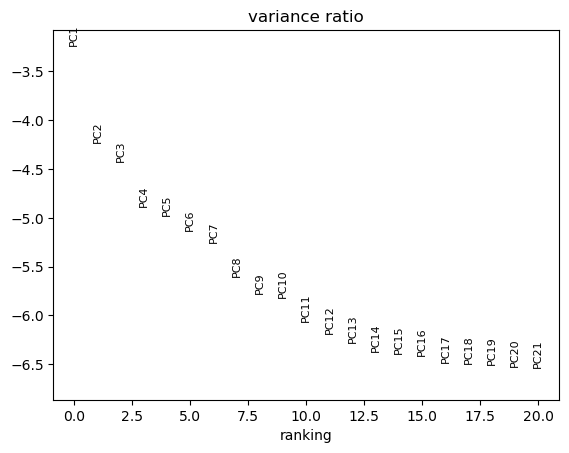

Variance explained by first 10 PCs: 10.10%
Variance explained by first 20 PCs: 11.83%


In [14]:
# Perform PCA
sc.tl.pca(adata, svd_solver="arpack", n_comps=50)

# Remove outliers for cleaner PCA visualization
# Identify cells that are extreme outliers in PC1 and PC2 space
pc1_coords = adata.obsm["X_pca"][:, 0]
pc2_coords = adata.obsm["X_pca"][:, 1]

# Calculate percentiles for outlier detection
pc1_lower, pc1_upper = np.percentile(pc1_coords, [1, 90])
pc2_lower, pc2_upper = np.percentile(pc2_coords, [1, 90])

# Identify non-outlier cells (within 1st-90th percentile range)
non_outlier_mask = (
    (pc1_coords >= pc1_lower)
    & (pc1_coords <= pc1_upper)
    & (pc2_coords >= pc2_lower)
    & (pc2_coords <= pc2_upper)
)

# Create a temporary dataset without outliers for plotting
adata_plot = adata[non_outlier_mask].copy()

print(
    f"Removed {(~non_outlier_mask).sum()} outlier cells for cleaner PCA visualization"
)
print(f"Plotting {adata_plot.shape[0]} cells out of {adata.shape[0]} total cells")

# Plot original PCA results (with outliers)
print("\n=== Original PCA plots (with outliers) ===")
# PCA plot colored by genotype - original
sc.pl.pca(adata, color="genotype", size=30, alpha=0.7)

# PCA plot colored by total counts - original
sc.pl.pca(adata, color="total_counts", size=30, alpha=0.7)

# PCA plot colored by number of genes - original
sc.pl.pca(adata, color="n_genes_by_counts", size=30, alpha=0.7)

# Plot cleaned PCA results (without outliers)
print("\n=== Cleaned PCA plots (outliers removed) ===")
# PCA plot colored by genotype - cleaned
sc.pl.pca(adata_plot, color="genotype", size=30, alpha=0.7)

# PCA plot colored by total counts - cleaned
sc.pl.pca(adata_plot, color="total_counts", size=30, alpha=0.7)

# PCA plot colored by number of genes - cleaned
sc.pl.pca(adata_plot, color="n_genes_by_counts", size=30, alpha=0.7)

# Plot variance explained by each PC (using original data)
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=20)

print(
    f"Variance explained by first 10 PCs: {adata.uns['pca']['variance_ratio'][:10].sum():.2%}"
)
print(
    f"Variance explained by first 20 PCs: {adata.uns['pca']['variance_ratio'][:20].sum():.2%}"
)

## Step 7: Neighborhood Graph and UMAP

/opt/conda/envs/experimenting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


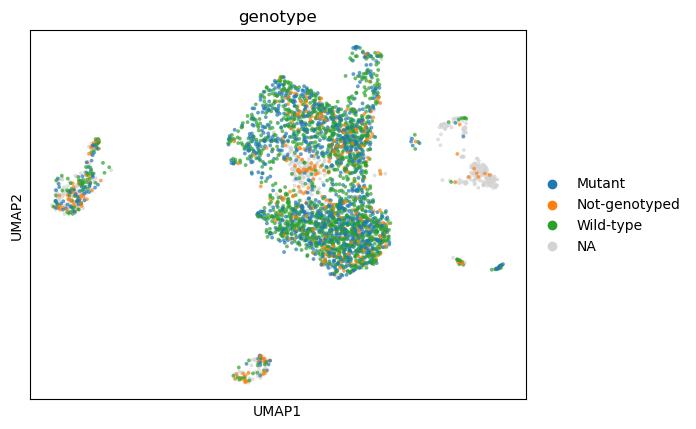

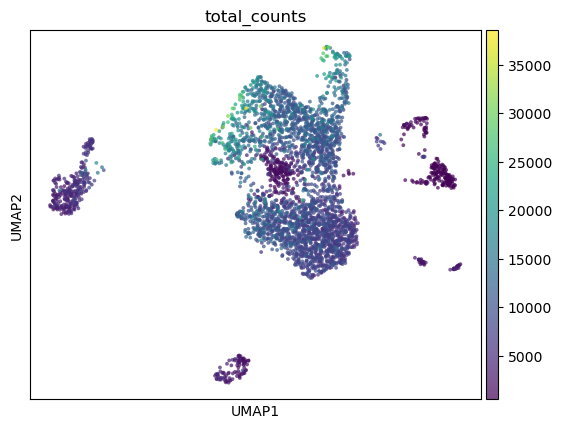

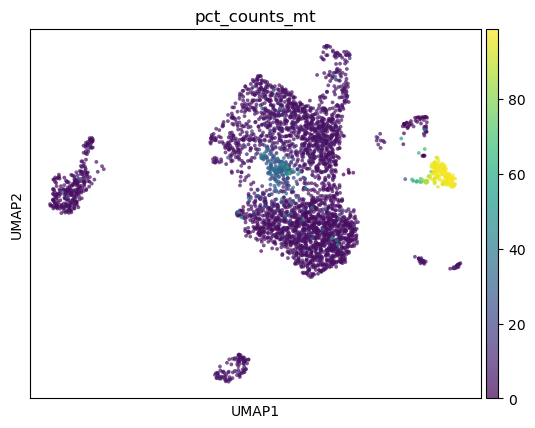

In [15]:
# Compute neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Compute UMAP
sc.tl.umap(adata)

# Plot UMAP as separate plots
# UMAP colored by genotype
sc.pl.umap(adata, color="genotype", legend_loc="right margin", size=30, alpha=0.7)

# UMAP colored by total counts
sc.pl.umap(adata, color="total_counts", size=30, alpha=0.7)

# UMAP colored by mitochondrial percentage
sc.pl.umap(adata, color="pct_counts_mt", size=30, alpha=0.7)

# Differential Expression Analysis: Mutant vs Wild-type

Now we'll perform a comprehensive differential expression analysis between mutant (MT) and wild-type (WT) cells to identify genes that are significantly different between the two conditions. We'll exclude the not-genotyped (NG) cells from this analysis.

In [16]:
# Prepare data for differential expression analysis
# Filter out not-genotyped cells for a clean comparison
adata_de = adata[adata.obs["genotype"].isin(["Mutant", "Wild-type"])].copy()

print(f"Original dataset: {adata.shape[0]} cells")
print(f"Filtered dataset for DE analysis: {adata_de.shape[0]} cells")
print(f"Genotype distribution in DE dataset:")
print(adata_de.obs["genotype"].value_counts())

# Use log-normalized data for differential expression (not scaled data)
# Reset X to log-normalized values
adata_de.X = adata_de.layers["log_normalized"].copy()

print(f"\nUsing log-normalized data for DE analysis")
print(f"Expression range: {adata_de.X.min():.3f} to {adata_de.X.max():.3f}")

Original dataset: 3487 cells
Filtered dataset for DE analysis: 2520 cells
Genotype distribution in DE dataset:
genotype
Wild-type    1435
Mutant       1085
Name: count, dtype: int64

Using log-normalized data for DE analysis
Expression range: 0.000 to 7.246


In [17]:
# Perform differential expression analysis using Wilcoxon rank-sum test
# This is a robust non-parametric test suitable for single-cell data

print("Performing differential expression analysis...")
print("Method: Wilcoxon rank-sum test")
print("Comparison: Mutant vs Wild-type")

# Run differential expression test
sc.tl.rank_genes_groups(
    adata_de,
    "genotype",
    groups=["Mutant"],
    reference="Wild-type",
    method="wilcoxon",
    use_raw=False,  # Use current X (log-normalized)
    n_genes=adata_de.shape[1],  # Test all genes
)

print("Differential expression analysis completed!")

# Extract results into a pandas DataFrame for easier manipulation
de_results = sc.get.rank_genes_groups_df(adata_de, group="Mutant")
de_results = de_results.sort_values("pvals_adj", ascending=True)

print(f"\nTotal genes tested: {len(de_results)}")
print(
    f"Significantly upregulated genes (padj < 0.05, logFC > 0.5): {len(de_results[(de_results['pvals_adj'] < 0.05) & (de_results['logfoldchanges'] > 0.5)])}"
)
print(
    f"Significantly downregulated genes (padj < 0.05, logFC < -0.5): {len(de_results[(de_results['pvals_adj'] < 0.05) & (de_results['logfoldchanges'] < -0.5)])}"
)

# Display top upregulated and downregulated genes
print("\n=== Top 10 upregulated genes in Mutant vs Wild-type ===")
top_up = de_results[(de_results["logfoldchanges"] > 0)].head(10)
for _, row in top_up.iterrows():
    print(
        f"{row['names']}: logFC = {row['logfoldchanges']:.3f}, padj = {row['pvals_adj']:.2e}"
    )

print("\n=== Top 10 downregulated genes in Mutant vs Wild-type ===")
top_down = de_results[(de_results["logfoldchanges"] < 0)].head(10)
for _, row in top_down.iterrows():
    print(
        f"{row['names']}: logFC = {row['logfoldchanges']:.3f}, padj = {row['pvals_adj']:.2e}"
    )

de_results.head()

Performing differential expression analysis...
Method: Wilcoxon rank-sum test
Comparison: Mutant vs Wild-type
Differential expression analysis completed!

Total genes tested: 32738
Significantly upregulated genes (padj < 0.05, logFC > 0.5): 0
Significantly downregulated genes (padj < 0.05, logFC < -0.5): 0

=== Top 10 upregulated genes in Mutant vs Wild-type ===
TMED2: logFC = 0.178, padj = 1.00e+00
SRSF2: logFC = 0.144, padj = 1.00e+00
URM1: logFC = 0.217, padj = 1.00e+00
CYCS: logFC = 0.239, padj = 1.00e+00
SRSF7: logFC = 0.112, padj = 1.00e+00
GNG5: logFC = 0.085, padj = 1.00e+00
TBXAS1: logFC = 0.233, padj = 1.00e+00
LSM3: logFC = 0.155, padj = 1.00e+00
DCXR: logFC = 0.226, padj = 1.00e+00
CLU: logFC = 0.208, padj = 1.00e+00

=== Top 10 downregulated genes in Mutant vs Wild-type ===
TBC1D10C: logFC = -0.374, padj = 1.00e+00
LMAN2: logFC = -0.207, padj = 1.00e+00
ROMO1: logFC = -0.218, padj = 1.00e+00
AKAP9: logFC = -0.185, padj = 1.00e+00
H2AFY: logFC = -0.096, padj = 1.00e+00
RPSA

,names,scores,logfoldchanges,pvals,pvals_adj
32728,TBC1D10C,-2.614268,-0.374329,0.008942,1.0
32729,LMAN2,-2.620377,-0.206939,0.008783,1.0
32730,ROMO1,-2.635361,-0.217968,0.008405,1.0
32731,AKAP9,-2.670914,-0.184769,0.007564,1.0
32732,H2AFY,-2.673347,-0.095913,0.007510,1.0


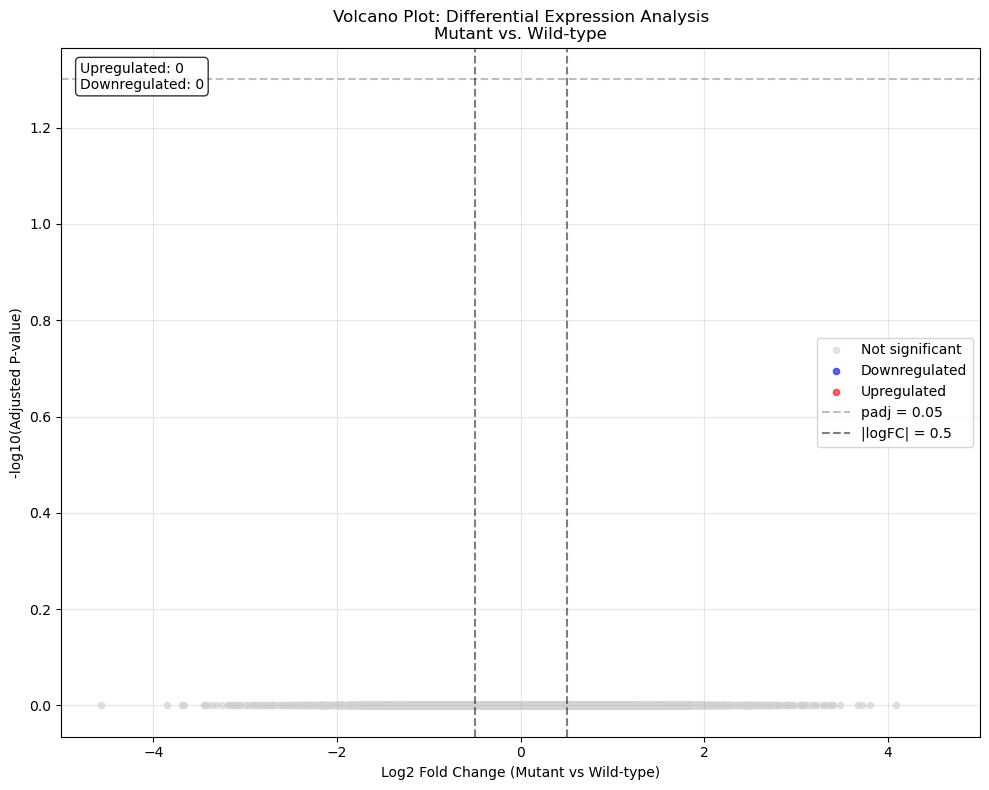

Volcano plot created!
Significantly upregulated genes (padj < 0.05, logFC > 0.5): 0
Significantly downregulated genes (padj < 0.05, logFC < -0.5): 0
Significant genes:



,names,scores,logfoldchanges,pvals,pvals_adj,-log10_padj,significance


In [18]:
# Create volcano plot
plt.figure(figsize=(10, 8))

# Calculate -log10(padj) for y-axis
de_results["-log10_padj"] = -np.log10(de_results["pvals_adj"])

# Define significance thresholds
padj_threshold = 0.05
logfc_threshold = 0.5

# Create color categories
de_results["significance"] = "Not significant"
de_results.loc[
    (de_results["pvals_adj"] < padj_threshold)
    & (de_results["logfoldchanges"] > logfc_threshold),
    "significance",
] = "Upregulated"
de_results.loc[
    (de_results["pvals_adj"] < padj_threshold)
    & (de_results["logfoldchanges"] < -logfc_threshold),
    "significance",
] = "Downregulated"

# Color mapping
colors = {"Not significant": "lightgray", "Upregulated": "red", "Downregulated": "blue"}

# Create the plot
for category in ["Not significant", "Downregulated", "Upregulated"]:
    subset = de_results[de_results["significance"] == category]
    plt.scatter(
        subset["logfoldchanges"],
        subset["-log10_padj"],
        c=colors[category],
        alpha=0.6,
        s=20,
        label=category,
    )

# Set x limit to +/- 10
plt.xlim(-5, 5)

# Add threshold lines
plt.axhline(
    y=-np.log10(padj_threshold),
    color="gray",
    linestyle="--",
    alpha=0.5,
    label=f"padj = {padj_threshold}",
)
plt.axvline(
    x=logfc_threshold,
    color="black",
    linestyle="--",
    alpha=0.5,
    label=f"|logFC| = {logfc_threshold}",
)
plt.axvline(
    x=-logfc_threshold,
    color="black",
    linestyle="--",
    alpha=0.5,
)

# Annotate top genes that pass both significance thresholds
sig_genes = de_results[
    (de_results["pvals_adj"] < padj_threshold)
    & (abs(de_results["logfoldchanges"]) > logfc_threshold)
]

plt.xlabel("Log2 Fold Change (Mutant vs Wild-type)")
plt.ylabel("-log10(Adjusted P-value)")
plt.title("Volcano Plot: Differential Expression Analysis\nMutant vs. Wild-type")
plt.legend()
plt.grid(True, alpha=0.3)

# Add statistics text
n_up = len(de_results[de_results["significance"] == "Upregulated"])
n_down = len(de_results[de_results["significance"] == "Downregulated"])
plt.text(
    0.02,
    0.98,
    f"Upregulated: {n_up}\nDownregulated: {n_down}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

print(f"Volcano plot created!")
print(
    f"Significantly upregulated genes (padj < {padj_threshold}, logFC > {logfc_threshold}): {n_up}"
)
print(
    f"Significantly downregulated genes (padj < {padj_threshold}, logFC < -{logfc_threshold}): {n_down}"
)
print("Significant genes:\n")
sig_genes

Creating dot plot for 0 genes:
- 0 upregulated genes
- 0 downregulated genes


ValueError: max() arg is an empty sequence

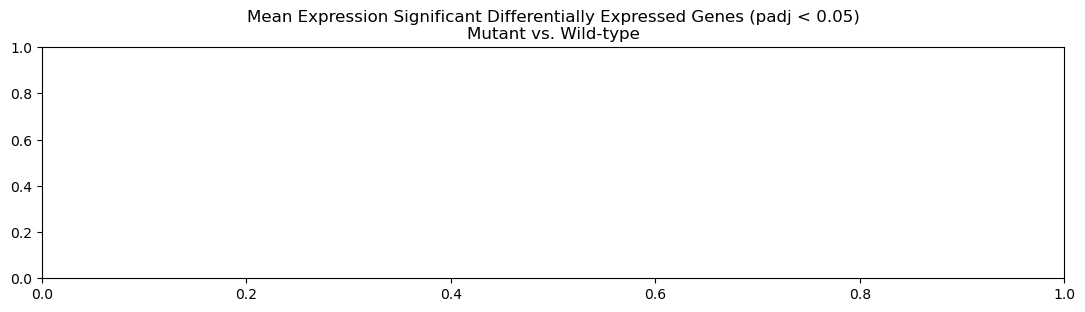

In [19]:
# Create dot plot of top differentially expressed genes
# Select top upregulated and downregulated genes
top_up_genes = (
    de_results[(de_results["logfoldchanges"] > 0) & (de_results["pvals_adj"] < 0.05)]
    .sort_values("logfoldchanges", ascending=False)["names"]
    .tolist()
)

top_down_genes = (
    de_results[(de_results["logfoldchanges"] < 0) & (de_results["pvals_adj"] < 0.05)]
    .sort_values("logfoldchanges", ascending=False)["names"]
    .tolist()
)

# Combine top up and down genes
dot_plot_genes = top_up_genes + top_down_genes

print(f"Creating dot plot for {len(dot_plot_genes)} genes:")
print(f"- {len(top_up_genes)} upregulated genes")
print(f"- {len(top_down_genes)} downregulated genes")

# Create dot plot
sc.pl.dotplot(
    adata_de,
    var_names=dot_plot_genes,
    groupby="genotype",
    categories_order=["Wild-type", "Mutant"],
    figsize=(15, 3),
    standard_scale="var",  # Scale genes to have mean=0, var=1,
    title="Mean Expression Significant Differentially Expressed Genes (padj < 0.05)\nMutant vs. Wild-type",
    # var_group_rotation=45,
)

plt.tight_layout()
plt.show()

In [ ]:
# Create violin plots for top individual genes
# Select the most significant genes for detailed visualization
top_genes_for_violin = (
    de_results.loc[de_results["significance"] != "Not significant"]
    .sort_values(by="logfoldchanges", ascending=False)["names"]
    .tolist()
)

print(
    f"Creating violin plots for top {len(top_genes_for_violin)} differentially expressed genes"
)

# Calculate optimal grid size
import math

n_genes = len(top_genes_for_violin)
n_cols = 4
n_rows = math.ceil(n_genes / n_cols)

# Create violin plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()

for i, gene in enumerate(top_genes_for_violin):
    if gene in adata_de.var_names:
        # Extract expression data for this gene
        gene_expr = adata_de[:, gene].X
        if hasattr(gene_expr, "toarray"):
            gene_expr = gene_expr.toarray().flatten()
        else:
            gene_expr = gene_expr.flatten()

        # Create DataFrame for plotting
        plot_data = pd.DataFrame(
            {"expression": gene_expr, "genotype": adata_de.obs["genotype"].values}
        )

        # Create violin plot
        sns.violinplot(data=plot_data, x="genotype", y="expression", ax=axes[i])
        axes[i].set_title(f"{gene}", fontsize=12)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Log Expression")

        # Add statistical info
        gene_stats = de_results[de_results["names"] == gene].iloc[0]
        axes[i].text(
            0.5,
            0.95,
            f'logFC: {gene_stats["logfoldchanges"]:.2f}\npadj: {gene_stats["pvals_adj"]:.1e}',
            transform=axes[i].transAxes,
            ha="center",
            va="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
            fontsize=8,
        )

# Hide unused subplots
for j in range(n_genes, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(
    "Expression Distribution of Significant Differentially Expressed Genes (padj < 0.05 and |logFC| > 0.5)\nMutant vs. Wild-type",
    fontsize=16,
)
plt.tight_layout()
plt.show()

In [ ]:
# Create violin plots for top individual genes
# Select the most significant genes for detailed visualization
top_genes_for_violin = top_up_genes + top_down_genes

print(
    f"Creating violin plots for top {len(top_genes_for_violin)} differentially expressed genes"
)

# Calculate optimal grid size
import math

n_genes = len(top_genes_for_violin)
n_cols = 6
n_rows = math.ceil(n_genes / n_cols)

# Create violin plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for i, gene in enumerate(top_genes_for_violin):
    if gene in adata_de.var_names:
        # Extract expression data for this gene
        gene_expr = adata_de[:, gene].X
        if hasattr(gene_expr, "toarray"):
            gene_expr = gene_expr.toarray().flatten()
        else:
            gene_expr = gene_expr.flatten()

        # Create DataFrame for plotting
        plot_data = pd.DataFrame(
            {"expression": gene_expr, "genotype": adata_de.obs["genotype"].values}
        )

        # Create violin plot
        sns.violinplot(data=plot_data, x="genotype", y="expression", ax=axes[i])
        axes[i].set_title(f"{gene}", fontsize=12, fontweight="bold")
        axes[i].set_xlabel("")
        axes[i].set_ylabel("Log Expression")

        # Add statistical info
        gene_stats = de_results[de_results["names"] == gene].iloc[0]
        axes[i].text(
            0.5,
            0.95,
            f'logFC: {gene_stats["logfoldchanges"]:.2f}\npadj: {gene_stats["pvals_adj"]:.1e}',
            transform=axes[i].transAxes,
            ha="center",
            va="top",
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7),
            fontsize=8,
        )

# Hide unused subplots
for j in range(n_genes, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(
    "Expression Distribution of Significant Differentially Expressed Genes (padj < 0.05)\nMutant vs. Wild-type",
    fontsize=16,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Gene Set Enrichment Analysis (GSEA): Mutant vs Wild-type Comparison

Now we'll perform Gene Set Enrichment Analysis to compare pathway activities between mutant and wild-type cells. We'll use two complementary approaches:

1. **Separate GSEA Analysis** - Run GSEA independently on mutant and wild-type cells to identify active pathways in each condition
2. **Differential Pathway Analysis** - Compare pathway enrichment scores between conditions to identify differentially active pathways
3. **Multiple Gene Set Databases** - Including GO, KEGG, Reactome, and MSigDB collections

This approach will help us understand which biological pathways are specifically activated or suppressed in the mutant compared to wild-type cells.

In [20]:
import gseapy as gp
from gseapy import barplot, dotplot

# Additional imports for GSEA analysis
import requests
import json
from scipy import stats

In [21]:
# Prepare data for differential GSEA analysis
print("Preparing data for differential GSEA analysis...")

# Separate cells by genotype for independent GSEA analysis
mutant_cells = adata_de[adata_de.obs["genotype"] == "Mutant"].copy()
wildtype_cells = adata_de[adata_de.obs["genotype"] == "Wild-type"].copy()

print(f"Mutant cells: {mutant_cells.shape[0]}")
print(f"Wild-type cells: {wildtype_cells.shape[0]}")

# Calculate mean expression for each gene in each condition
mutant_mean_expr = pd.Series(
    data=np.array(mutant_cells.X.mean(axis=0)).flatten(), index=mutant_cells.var_names
)

wildtype_mean_expr = pd.Series(
    data=np.array(wildtype_cells.X.mean(axis=0)).flatten(),
    index=wildtype_cells.var_names,
)

# Calculate gene rankings for each condition
# Use mean expression as the ranking metric for GSEA
mutant_ranking = mutant_mean_expr.sort_values(ascending=False)
wildtype_ranking = wildtype_mean_expr.sort_values(ascending=False)

print(f"Gene rankings prepared for both conditions")
print(f"Top 5 genes in mutant: {list(mutant_ranking.head().index)}")
print(f"Top 5 genes in wild-type: {list(wildtype_ranking.head().index)}")

print(f"\nWe now have three rankings:")
print(f"1. Mutant cell expression ranking ({len(mutant_ranking)} genes)")
print(f"2. Wild-type cell expression ranking ({len(wildtype_ranking)} genes)")

Preparing data for differential GSEA analysis...
Mutant cells: 1085
Wild-type cells: 1435
Gene rankings prepared for both conditions
Top 5 genes in mutant: ['MALAT1', 'RPS18', 'EEF1A1', 'RPL10', 'RPS12']
Top 5 genes in wild-type: ['MALAT1', 'RPS18', 'EEF1A1', 'RPL10', 'RPS12']

We now have three rankings:
1. Mutant cell expression ranking (32738 genes)
2. Wild-type cell expression ranking (32738 genes)


In [ ]:
# Run GSEA Analysis for Each Condition
print("Running GSEA analysis for each condition...")

# Define gene set libraries to test
gene_set_libraries = [
    "GO_Biological_Process_2023",
    "KEGG_2021_Human",
    "Reactome_2022",
    "MSigDB_Hallmark_2020",
]

# Run GSEA for mutant cells
print("\n=== GSEA Analysis for Mutant Cells ===")
mutant_gsea_results = {}

for library in gene_set_libraries:
    print(f"Analyzing {library} in mutant cells...")

    mutant_res = gp.prerank(
        rnk=mutant_ranking,
        gene_sets=library,
        processes=4,
        permutation_num=1000,
        outdir=None,
        format="png",
        seed=42,
    )

    mutant_res.res2d[["ES", "NES", "NOM p-val", "FDR q-val", "FWER p-val"]] = (
        mutant_res.res2d[["ES", "NES", "NOM p-val", "FDR q-val", "FWER p-val"]].astype(
            float
        )
    )

    mutant_gsea_results[library] = mutant_res

    # Show top results
    if len(mutant_res.res2d) > 0:
        sig_results = mutant_res.res2d[mutant_res.res2d["FDR q-val"] < 0.25]
        print(f"  Significant pathways (FDR < 0.25): {len(sig_results)}")
    else:
        print(f"  No significant results")


# Run GSEA for wild-type cells
print("\n=== GSEA Analysis for Wild-type Cells ===")
wildtype_gsea_results = {}

for library in gene_set_libraries:
    print(f"Analyzing {library} in wild-type cells...")

    wildtype_res = gp.prerank(
        rnk=wildtype_ranking,
        gene_sets=library,
        processes=4,
        permutation_num=1000,
        outdir=None,
        format="png",
        seed=42,
    )

    wildtype_res.res2d[["ES", "NES", "NOM p-val", "FDR q-val", "FWER p-val"]] = (
        wildtype_res.res2d[
            ["ES", "NES", "NOM p-val", "FDR q-val", "FWER p-val"]
        ].astype(float)
    )

    wildtype_gsea_results[library] = wildtype_res

    # Show top results
    if len(wildtype_res.res2d) > 0:
        sig_results = wildtype_res.res2d[wildtype_res.res2d["FDR q-val"] < 0.25]
        print(f"  Significant pathways (FDR < 0.25): {len(sig_results)}")
    else:
        print(f"  No significant results")


print("\nGSEA analysis completed for both conditions!")

/var/tmp/ipykernel_2516346/843548834.py:19: DeprecationWarning: processes is deprecated; use threads
  mutant_res = gp.prerank(
2025-07-24 01:05:34,921 [WARNING] Duplicated values found in preranked stats: 48.25% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [ ]:
# Compare Pathway Activities Between Conditions
print("Comparing pathway activities between mutant and wild-type...")


# Function to compare GSEA results between conditions
def compare_pathway_activities(
    mutant_results, wildtype_results, library_name, fdr_threshold=0.25
):
    """Compare pathway enrichment between mutant and wild-type conditions"""

    print(f"\n=== {library_name} Comparison ===")

    if mutant_results is None or wildtype_results is None:
        print("Missing results for comparison")
        return None

    # Get significant results from each condition
    mutant_sig = mutant_results.res2d[
        mutant_results.res2d["FDR q-val"] < fdr_threshold
    ].copy()
    wildtype_sig = wildtype_results.res2d[
        wildtype_results.res2d["FDR q-val"] < fdr_threshold
    ].copy()

    print(f"Significant pathways in mutant: {len(mutant_sig)}")
    print(f"Significant pathways in wild-type: {len(wildtype_sig)}")

    # Merge results to compare NES scores
    mutant_sig = mutant_sig[["Term", "NES", "FDR q-val"]].copy()
    wildtype_sig = wildtype_sig[["Term", "NES", "FDR q-val"]].copy()

    mutant_sig.columns = ["Term", "Mutant_NES", "Mutant_FDR"]
    wildtype_sig.columns = ["Term", "Wildtype_NES", "Wildtype_FDR"]

    # Find pathways significant in both conditions
    shared_pathways = pd.merge(mutant_sig, wildtype_sig, on="Term", how="inner")

    # Find pathways unique to each condition
    mutant_unique = mutant_sig[~mutant_sig["Term"].isin(wildtype_sig["Term"])]
    wildtype_unique = wildtype_sig[~wildtype_sig["Term"].isin(mutant_sig["Term"])]

    print(f"Pathways significant in both conditions: {len(shared_pathways)}")
    print(f"Pathways unique to mutant: {len(mutant_unique)}")
    print(f"Pathways unique to wild-type: {len(wildtype_unique)}")

    # Calculate differential enrichment for shared pathways
    if len(shared_pathways) > 0:
        shared_pathways["NES_difference"] = (
            shared_pathways["Mutant_NES"] - shared_pathways["Wildtype_NES"]
        )
        shared_pathways["Abs_NES_difference"] = abs(shared_pathways["NES_difference"])

        # Sort by absolute difference
        shared_pathways = shared_pathways.sort_values(
            "Abs_NES_difference", ascending=False
        )

        print(f"\nTop 5 most differentially enriched shared pathways:")
        for _, row in shared_pathways.head().iterrows():
            direction = "↑" if row["NES_difference"] > 0 else "↓"
            print(f"  {direction} {row['Term'][:60]}: Δ={row['NES_difference']:.3f}")

    # Show top unique pathways
    if len(mutant_unique) > 0:
        print(f"\nTop 5 pathways unique to mutant:")
        for _, row in mutant_unique.nlargest(5, "Mutant_NES").iterrows():
            print(f"  + {row['Term'][:60]}: NES={row['Mutant_NES']:.3f}")

    if len(wildtype_unique) > 0:
        print(f"\nTop 5 pathways unique to wild-type:")
        for _, row in wildtype_unique.nlargest(5, "Wildtype_NES").iterrows():
            print(f"  + {row['Term'][:60]}: NES={row['Wildtype_NES']:.3f}")

    return {
        "shared": shared_pathways,
        "mutant_unique": mutant_unique,
        "wildtype_unique": wildtype_unique,
    }


# Compare results for each library
comparison_results = {}

for library in gene_set_libraries:
    if library in mutant_gsea_results and library in wildtype_gsea_results:
        comparison_results[library] = compare_pathway_activities(
            mutant_gsea_results[library], wildtype_gsea_results[library], library
        )

In [ ]:
# Plot 1: Shared Pathways - Differential Enrichment
print("Creating plots for shared pathways differential enrichment...")

for library_name, results in comparison_results.items():
    if results is None:
        continue

    shared = results["shared"]

    if len(shared) > 0:
        plt.figure(figsize=(12, 8))

        top_shared = shared.head(15)
        colors = ["red" if x > 0 else "blue" for x in top_shared["NES_difference"]]

        plt.barh(
            range(len(top_shared)),
            top_shared["NES_difference"],
            color=colors,
            alpha=0.7,
        )
        plt.yticks(range(len(top_shared)))
        plt.gca().set_yticklabels(
            [
                term[:50] + "..." if len(term) > 50 else term
                for term in top_shared["Term"]
            ],
            fontsize=10,
        )
        plt.xlabel("NES Difference (Mutant - Wild-type)", fontsize=12)
        plt.title(
            f"Differential Enrichment in Shared Pathways - {library_name}\n(n={len(shared)})",
            fontsize=14,
            fontweight="bold",
        )
        plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
        plt.grid(True, alpha=0.3)

        # Add legend
        plt.text(
            0.02,
            0.98,
            "Red: Higher in Mutant\nBlue: Higher in Wild-type",
            transform=plt.gca().transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
            fontsize=10,
        )

        plt.tight_layout()
        plt.show()
    else:
        print(f"No shared pathways found for {library_name}")

print("Shared pathways plots completed!")

In [ ]:
# Plot 2: Mutant-Unique Pathways
print("Creating plots for mutant-unique pathways...")

for library_name, results in comparison_results.items():
    if results is None:
        continue

    mutant_unique = results["mutant_unique"]

    if len(mutant_unique) > 0:
        plt.figure(figsize=(12, 8))

        top_mutant = mutant_unique.nlargest(15, "Mutant_NES")

        plt.barh(
            range(len(top_mutant)), top_mutant["Mutant_NES"], color="red", alpha=0.7
        )
        plt.yticks(range(len(top_mutant)))
        plt.gca().set_yticklabels(
            [
                term[:50] + "..." if len(term) > 50 else term
                for term in top_mutant["Term"]
            ],
            fontsize=10,
        )
        plt.xlabel("NES", fontsize=12)
        plt.title(
            f"Pathways Unique to Mutant - {library_name}\n(n={len(mutant_unique)})",
            fontsize=14,
            fontweight="bold",
        )
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print(f"No mutant-unique pathways found for {library_name}")

print("Mutant-unique pathways plots completed!")

In [ ]:
# Plot 3: Wild-type-Unique Pathways
print("Creating plots for wild-type-unique pathways...")

for library_name, results in comparison_results.items():
    if results is None:
        continue

    wildtype_unique = results["wildtype_unique"]

    if len(wildtype_unique) > 0:
        plt.figure(figsize=(12, 8))

        top_wildtype = wildtype_unique.nlargest(15, "Wildtype_NES")

        plt.barh(
            range(len(top_wildtype)),
            top_wildtype["Wildtype_NES"],
            color="blue",
            alpha=0.7,
        )
        plt.yticks(range(len(top_wildtype)))
        plt.gca().set_yticklabels(
            [
                term[:50] + "..." if len(term) > 50 else term
                for term in top_wildtype["Term"]
            ],
            fontsize=10,
        )
        plt.xlabel("NES", fontsize=12)
        plt.title(
            f"Pathways Unique to Wild-type - {library_name}\n(n={len(wildtype_unique)})",
            fontsize=14,
            fontweight="bold",
        )
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    else:
        print(f"No wild-type-unique pathways found for {library_name}")

print("Wild-type-unique pathways plots completed!")

In [ ]:
# Plot 4: Pathway Distribution Summary
print("Creating pathway distribution summary plots...")

for library_name, results in comparison_results.items():
    if results is None:
        continue

    shared = results["shared"]
    mutant_unique = results["mutant_unique"]
    wildtype_unique = results["wildtype_unique"]

    total_pathways = len(shared) + len(mutant_unique) + len(wildtype_unique)

    if total_pathways > 0:
        plt.figure(figsize=(10, 8))

        summary_data = [len(shared), len(mutant_unique), len(wildtype_unique)]
        summary_labels = ["Shared", "Mutant-unique", "Wild-type-unique"]
        colors = ["purple", "red", "blue"]

        bars = plt.bar(summary_labels, summary_data, color=colors, alpha=0.7)

        plt.title(
            f"Pathway Distribution - {library_name}\n(Total: {total_pathways} pathways)",
            fontsize=14,
            fontweight="bold",
        )
        plt.ylabel("Number of Pathways", fontsize=12)
        plt.xlabel("Pathway Category", fontsize=12)

        # Add count annotations on top of bars
        for bar, count in zip(bars, summary_data):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.5,
                str(count),
                ha="center",
                va="bottom",
                fontsize=12,
                fontweight="bold",
            )

        plt.tight_layout()
        plt.show()
    else:
        print(f"No significant pathways found for {library_name}")

print("Pathway distribution plots completed!")

In [ ]:
# Summary of Differential GSEA Results
print("Creating overall summary of differential GSEA results...")

# Combine results across all libraries for a comprehensive view
all_shared = []
all_mutant_unique = []
all_wildtype_unique = []

for library_name, results in comparison_results.items():
    if results is None:
        continue

    # Add library information to each result
    shared = results["shared"].copy()
    mutant_unique = results["mutant_unique"].copy()
    wildtype_unique = results["wildtype_unique"].copy()

    shared["Library"] = library_name
    mutant_unique["Library"] = library_name
    wildtype_unique["Library"] = library_name

    all_shared.append(shared)
    all_mutant_unique.append(mutant_unique)
    all_wildtype_unique.append(wildtype_unique)

# Combine all results
if all_shared:
    combined_shared = pd.concat(all_shared, ignore_index=True)
    combined_mutant_unique = pd.concat(all_mutant_unique, ignore_index=True)
    combined_wildtype_unique = pd.concat(all_wildtype_unique, ignore_index=True)

    print(f"\n=== OVERALL DIFFERENTIAL GSEA SUMMARY ===")
    print(f"Total shared pathways: {len(combined_shared)}")
    print(f"Total mutant-unique pathways: {len(combined_mutant_unique)}")
    print(f"Total wild-type-unique pathways: {len(combined_wildtype_unique)}")

    # Show top differentially enriched pathways across all libraries
    if len(combined_shared) > 0:
        print(f"\nTop 10 most differentially enriched pathways (across all libraries):")
        top_differential = combined_shared.nlargest(10, "Abs_NES_difference")
        display_df = top_differential[
            ["Term", "NES_difference", "Mutant_NES", "Wildtype_NES", "Library"]
        ].copy()
        display_df.columns = [
            "Pathway",
            "NES_Difference",
            "Mutant_NES",
            "Wildtype_NES",
            "Library",
        ]
        display(display_df)

    # Show top unique pathways
    if len(combined_mutant_unique) > 0:
        print(f"\nTop 5 strongest mutant-unique pathways:")
        top_mutant = combined_mutant_unique.nlargest(5, "Mutant_NES")
        display_df = top_mutant[["Term", "Mutant_NES", "Library"]].copy()
        display_df.columns = ["Pathway", "Mutant_NES", "Library"]
        print(display_df.to_string(index=False))

    if len(combined_wildtype_unique) > 0:
        print(f"\nTop 5 strongest wild-type-unique pathways:")
        top_wildtype = combined_wildtype_unique.nlargest(5, "Wildtype_NES")
        display_df = top_wildtype[["Term", "Wildtype_NES", "Library"]].copy()
        display_df.columns = ["Pathway", "Wildtype_NES", "Library"]
        print(display_df.to_string(index=False))

    # Save data for separate plots
    library_counts = {}
    for library in gene_set_libraries:
        if library in comparison_results and comparison_results[library] is not None:
            results = comparison_results[library]
            library_counts[library] = {
                "Shared": len(results["shared"]),
                "Mutant-unique": len(results["mutant_unique"]),
                "Wild-type-unique": len(results["wildtype_unique"]),
            }

else:
    print("No significant results found across any libraries")

In [ ]:
# Plot 5: Pathway Counts by Library
print("Creating pathway counts by library plot...")

if library_counts:
    plt.figure(figsize=(12, 8))

    df_counts = pd.DataFrame(library_counts).T
    df_counts.plot(
        kind="bar", color=["purple", "red", "blue"], alpha=0.7, figsize=(12, 8)
    )

    plt.title("Pathway Counts by Gene Set Library", fontsize=16)
    plt.xlabel("Gene Set Library", fontsize=14)
    plt.ylabel("Number of Pathways", fontsize=14)
    plt.legend(title="Pathway Type", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.3, axis="y")

    # Add count annotations on bars
    for container in plt.gca().containers:
        plt.gca().bar_label(container, fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No pathway counts data available")

print("Pathway counts by library plot completed!")

In [ ]:
# Plot 6: Top Differential Pathways
print("Creating top differential pathways plot...")

if len(combined_shared) > 0:
    plt.figure(figsize=(14, 10))

    top_10_diff = combined_shared.nlargest(10, "Abs_NES_difference")
    colors = ["red" if x > 0 else "blue" for x in top_10_diff["NES_difference"]]

    plt.barh(
        range(len(top_10_diff)),
        top_10_diff["NES_difference"],
        color=colors,
        alpha=0.7,
    )
    plt.yticks(range(len(top_10_diff)))
    plt.gca().set_yticklabels(
        [f"{term[:40]}..." if len(term) > 40 else term for term in top_10_diff["Term"]],
        fontsize=12,
    )
    plt.xlabel("NES Difference (Mutant - Wild-type)", fontsize=14)
    plt.title(
        "Top 10 Most Differentially Enriched Pathways", fontsize=16, fontweight="bold"
    )
    plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
    plt.grid(True, alpha=0.3)

    # Add legend
    plt.text(
        0.02,
        0.98,
        "Red: Higher in Mutant\nBlue: Higher in Wild-type",
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        fontsize=12,
    )

    plt.tight_layout()
    plt.show()
else:
    print("No shared pathways available for differential analysis")

print("Top differential pathways plot completed!")